# Spectral Multi-Omics Pipeline Demo Notebook

This notebook executes the `spectral-multiomics-engine` end-to-end and embeds:

- Tables
- Graphs
- Images
- Interactive renders

It is designed to be reproducible and shareable.

## 1) Environment Setup and Reproducibility Controls

We install/import required libraries, define paths, set random seeds, and print package versions.

In [1]:
import importlib
import json
import os
import random
import subprocess
import sys
import time
from pathlib import Path

import numpy as np
import pandas as pd

# Optional plotting/interactive stack (install if missing)
for pkg in ["matplotlib", "seaborn", "plotly", "ipywidgets"]:
    try:
        importlib.import_module(pkg)
    except Exception:
        subprocess.check_call([sys.executable, "-m", "pip", "install", pkg])

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import ipywidgets as widgets
from IPython.display import HTML, Image, display

# Reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)

ROOT = Path.cwd()
DATA_DIR = ROOT / "data" / "notebook_demo"
OUT_DIR = ROOT / "outputs" / "notebook_demo"
FIG_DIR = OUT_DIR / "figures"
MANIFEST_PATH = OUT_DIR / "artifact_manifest.json"

for p in [DATA_DIR, OUT_DIR, FIG_DIR]:
    p.mkdir(parents=True, exist_ok=True)

# Package versions
versions = {
    "python": sys.version.split()[0],
    "numpy": np.__version__,
    "pandas": pd.__version__,
    "matplotlib": plt.matplotlib.__version__,
    "seaborn": sns.__version__,
    "plotly": importlib.import_module("plotly").__version__,
}

pd.DataFrame(list(versions.items()), columns=["package", "version"])

,package,version
0,python,3.13.1
1,numpy,2.4.2
2,pandas,3.0.1
3,matplotlib,3.10.8
4,seaborn,0.13.2
5,plotly,6.5.2


## 2) Load Inputs and Pipeline Configuration

We create/load input files, validate expected schema, and preview dimensions.

In [2]:
from spectral_multiomics.synth import synth_dataset
from spectral_multiomics.contact_map import load_contact_map

# Create synthetic inputs for robust local reproducibility
paths = synth_dataset(DATA_DIR, n_bins=256, binsize=100_000, chrom="chr1", seed=SEED)
CONTACT_PATH = paths["contact"]
SIGNAL_PATH = paths["signal"]

config = {
    "contact": str(CONTACT_PATH),
    "signal": str(SIGNAL_PATH),
    "out_dir": str(OUT_DIR),
    "binsize": 100_000,
    "chrom": "chr1",
    "k": 16,
    "normalized_laplacian": True,
    "include_trivial": False,
    "agg": "mean",
}

# Validate signal schema preview
signal_preview = pd.read_csv(SIGNAL_PATH, sep="\t", header=None, names=["chrom", "start", "end", "value"])
required_cols = ["chrom", "start", "end", "value"]
assert list(signal_preview.columns) == required_cols

# Validate contact dimensions
A_preview = load_contact_map(CONTACT_PATH)
input_summary = pd.DataFrame(
    [
        ["contact_path", CONTACT_PATH],
        ["signal_path", SIGNAL_PATH],
        ["contact_shape", tuple(A_preview.shape)],
        ["signal_rows", len(signal_preview)],
        ["config_k", config["k"]],
    ],
    columns=["item", "value"],
)

display(input_summary)
signal_preview.head(8)

,item,value
0,contact_path,c:\Users\dunnm\Desktop\spectral-multiomics-eng...
1,signal_path,c:\Users\dunnm\Desktop\spectral-multiomics-eng...
2,contact_shape,"(256, 256)"
3,signal_rows,256
4,config_k,16


,chrom,start,end,value
0,chr1,0,100000,0.253491
1,chr1,100000,200000,-0.011548
2,chr1,200000,300000,0.505993
3,chr1,300000,400000,0.622012
4,chr1,400000,500000,-0.034069
5,chr1,500000,600000,0.193071
6,chr1,600000,700000,0.613400
7,chr1,700000,800000,0.562901


## 3) Execute Pipeline Stages with Captured Logs

We run each stage explicitly, capture timing, and report per-stage status.

In [3]:
from spectral_multiomics.binning import GenomicBins, bin_bedgraph
from spectral_multiomics.laplacian import laplacian_eigenvectors
from spectral_multiomics.pipeline import run_pipeline
from spectral_multiomics.projection import project_signal

stage_logs = []

# Stage 1: Load contact map
start = time.perf_counter()
A = load_contact_map(CONTACT_PATH)
stage_logs.append({"stage": "load_contact_map", "seconds": time.perf_counter() - start, "status": "ok"})

# Stage 2: Compute eigenvectors
start = time.perf_counter()
evals, evecs = laplacian_eigenvectors(
    A,
    k=config["k"],
    normalized=config["normalized_laplacian"],
    include_trivial=config["include_trivial"],
)
stage_logs.append({"stage": "laplacian_eigenvectors", "seconds": time.perf_counter() - start, "status": "ok"})

# Stage 3: Bin signal
start = time.perf_counter()
bins = GenomicBins(chrom=config["chrom"], start=0, binsize=config["binsize"], n_bins=A.shape[0])
y = bin_bedgraph(SIGNAL_PATH, bins, agg=config["agg"])
stage_logs.append({"stage": "bin_signal", "seconds": time.perf_counter() - start, "status": "ok"})

# Stage 4: Project signal
start = time.perf_counter()
coeffs = project_signal(evecs, y)
stage_logs.append({"stage": "project_signal", "seconds": time.perf_counter() - start, "status": "ok"})

# Stage 5: Run full pipeline wrapper (writes artifacts)
start = time.perf_counter()
out = run_pipeline(**config)
stage_logs.append({"stage": "run_pipeline_wrapper", "seconds": time.perf_counter() - start, "status": "ok"})

logs_df = pd.DataFrame(stage_logs)
logs_df["seconds"] = logs_df["seconds"].round(4)
display(logs_df)

,stage,seconds,status
0,load_contact_map,0.0030,ok
1,laplacian_eigenvectors,0.0033,ok
2,bin_signal,0.0031,ok
3,project_signal,0.0001,ok
4,run_pipeline_wrapper,0.0130,ok


## 4) Aggregate Outputs into Analysis-Ready Tables

We load output artifacts and build summary/QC tables for quick review.

In [4]:
evals_disk = np.load(out.evals_path)
evecs_disk = np.load(out.evecs_path)
y_disk = np.load(out.signal_binned_path)
proj_disk = np.load(out.projection_path)

qc_df = pd.DataFrame(
    {
        "metric": [
            "n_bins",
            "k",
            "eval_min",
            "eval_max",
            "signal_mean",
            "signal_std",
            "proj_l2_norm",
        ],
        "value": [
            int(evecs_disk.shape[0]),
            int(evecs_disk.shape[1]),
            float(evals_disk.min()),
            float(evals_disk.max()),
            float(y_disk.mean()),
            float(y_disk.std()),
            float(np.linalg.norm(proj_disk)),
        ],
    }
)

coeff_df = pd.DataFrame({
    "component": np.arange(1, len(proj_disk) + 1),
    "coefficient": proj_disk,
}).sort_values("component")

evals_df = pd.DataFrame({
    "component": np.arange(1, len(evals_disk) + 1),
    "eigenvalue": evals_disk,
})

display(qc_df)
display(coeff_df.head(16))
display(evals_df.head(16))

,metric,value
0,n_bins,256.000000
1,k,16.000000
2,eval_min,0.010975
3,eval_max,0.837145
4,signal_mean,0.389340
5,signal_std,0.635715
6,proj_l2_norm,9.500150


,component,coefficient
0,1,-7.663855
1,2,0.019932
2,3,2.259099
3,4,-0.031363
4,5,-1.747048
5,6,-1.702182
6,7,-2.703705
7,8,-0.390609
8,9,-3.288557
9,10,0.122849


,component,eigenvalue
0,1,0.010975
1,2,0.051255
2,3,0.095443
3,4,0.185664
4,5,0.244103
5,6,0.358661
6,7,0.416982
7,8,0.526907
8,9,0.574773
9,10,0.663591


## 5) Generate Quantitative Graphs for Key Metrics

We create static and interactive charts for spectrum, signal, and projection coefficients.

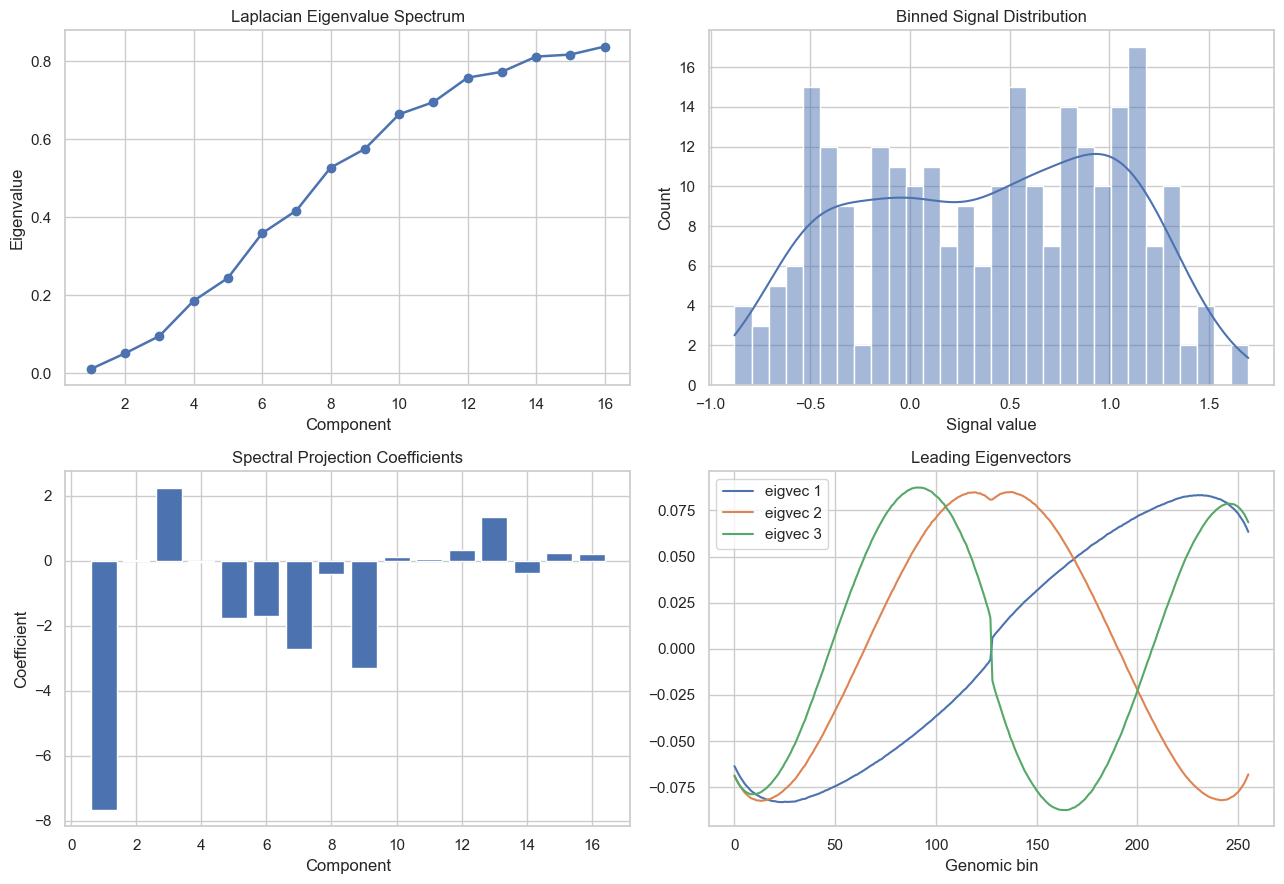

Interactive plot render skipped: Mime type rendering requires nbformat>=4.2.0 but it is not installed


In [6]:
if sns is not None:
    sns.set_theme(style="whitegrid")

fig, axes = plt.subplots(2, 2, figsize=(13, 9))

# Eigenvalue trend
axes[0, 0].plot(evals_df["component"], evals_df["eigenvalue"], marker="o", lw=1.8)
axes[0, 0].set_title("Laplacian Eigenvalue Spectrum")
axes[0, 0].set_xlabel("Component")
axes[0, 0].set_ylabel("Eigenvalue")

# Signal distribution
if sns is not None:
    sns.histplot(y_disk, bins=30, kde=True, ax=axes[0, 1])
else:
    axes[0, 1].hist(y_disk, bins=30)
axes[0, 1].set_title("Binned Signal Distribution")
axes[0, 1].set_xlabel("Signal value")

# Projection coefficients
axes[1, 0].bar(coeff_df["component"], coeff_df["coefficient"])
axes[1, 0].set_title("Spectral Projection Coefficients")
axes[1, 0].set_xlabel("Component")
axes[1, 0].set_ylabel("Coefficient")

# First 3 eigenvectors
for i in range(min(3, evecs_disk.shape[1])):
    axes[1, 1].plot(evecs_disk[:, i], label=f"eigvec {i+1}")
axes[1, 1].set_title("Leading Eigenvectors")
axes[1, 1].set_xlabel("Genomic bin")
axes[1, 1].legend()

plt.tight_layout()
plot_path_static = FIG_DIR / "quantitative_summary.png"
fig.savefig(plot_path_static, dpi=150, bbox_inches="tight")
plt.show()

# Interactive bar chart (plotly when available)
if px is not None:
    fig_bar = px.bar(coeff_df, x="component", y="coefficient", title="Interactive Projection Coefficients")
    try:
        fig_bar.show()
    except Exception as e:
        print(f"Interactive plot render skipped: {e}")
else:
    print("Plotly not installed; interactive bar chart skipped.")

## 6) Embed Image Outputs and Heatmaps

We render saved image artifacts inline and display annotated heatmaps.

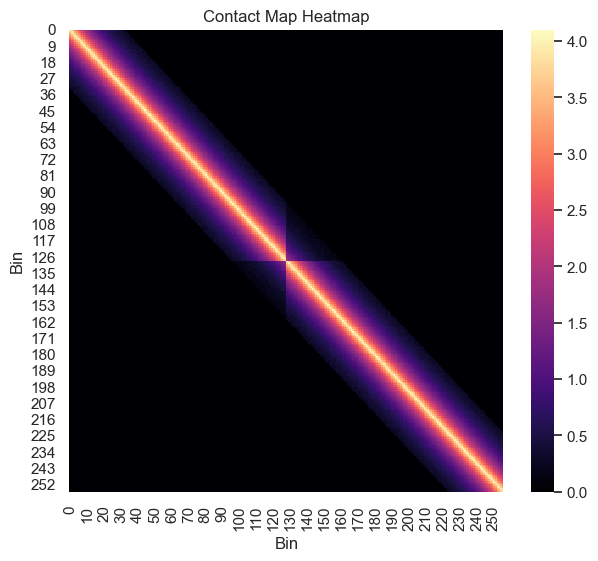

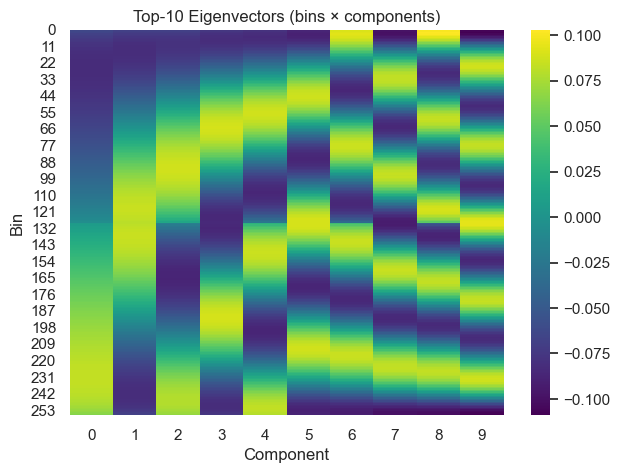

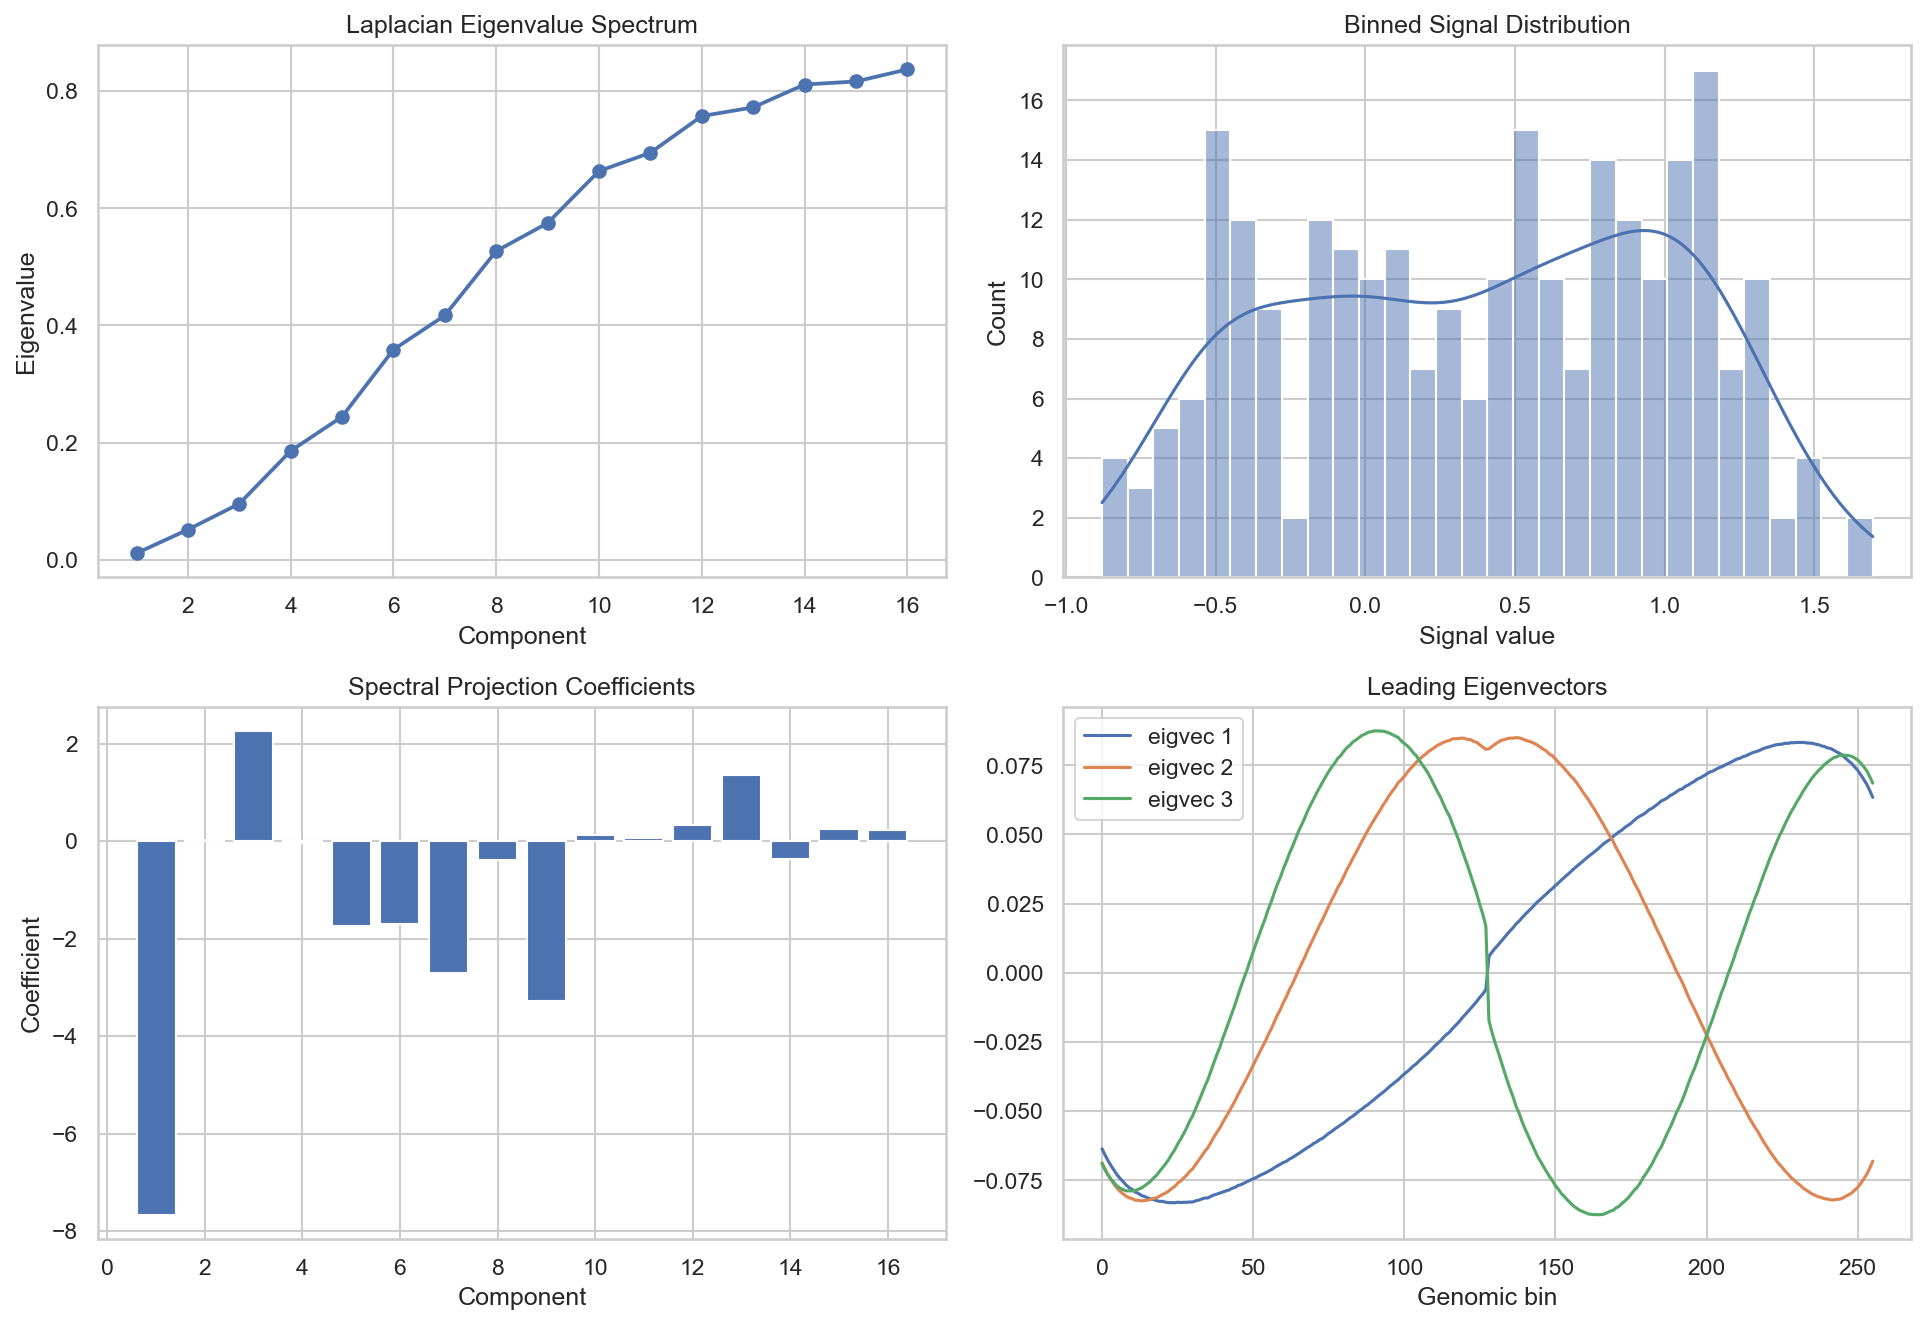

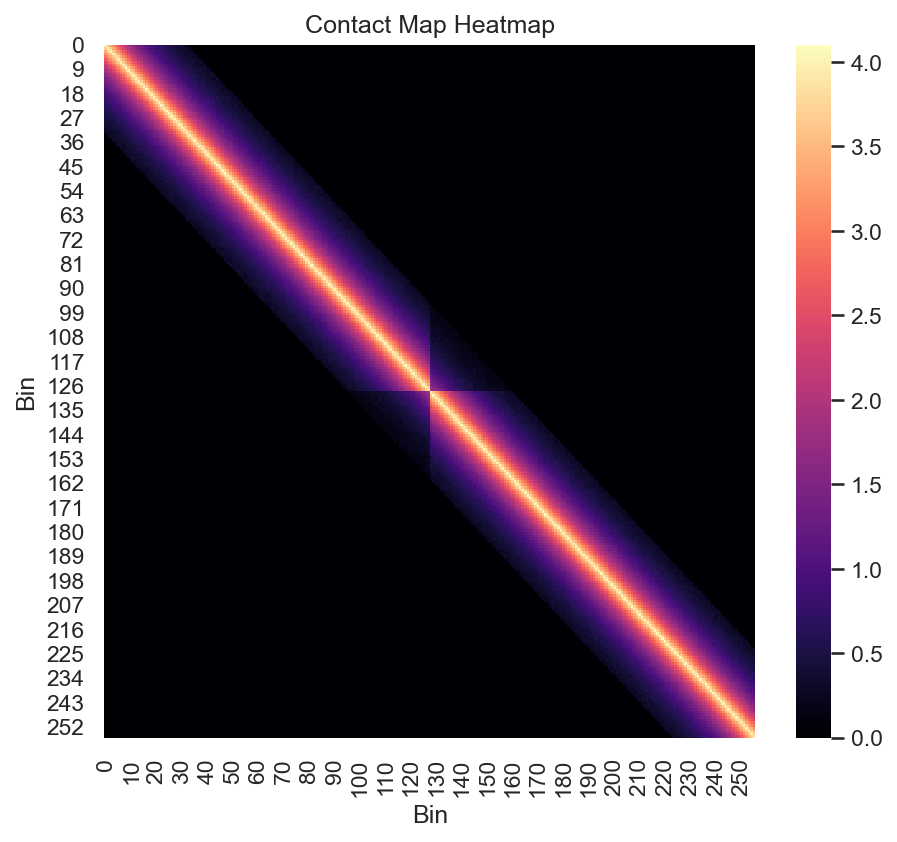

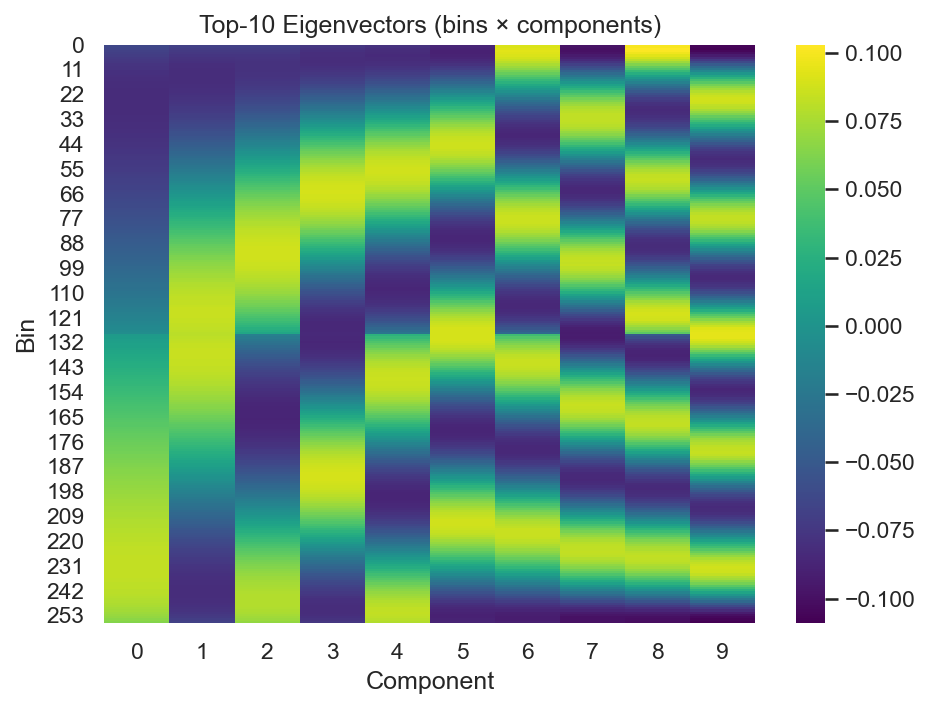

In [7]:
# Contact map heatmap (dense view for demo size)
A_dense = A.toarray()
fig_hm, ax = plt.subplots(figsize=(7, 6))
if sns is not None:
    sns.heatmap(A_dense, cmap="magma", ax=ax)
else:
    im = ax.imshow(A_dense, cmap="magma", aspect="auto")
    fig_hm.colorbar(im, ax=ax)
ax.set_title("Contact Map Heatmap")
ax.set_xlabel("Bin")
ax.set_ylabel("Bin")
heatmap_path = FIG_DIR / "contact_heatmap.png"
fig_hm.savefig(heatmap_path, dpi=150, bbox_inches="tight")
plt.show()

# Eigenvector heatmap
fig_ev, ax = plt.subplots(figsize=(7, 5))
if sns is not None:
    sns.heatmap(evecs_disk[:, :10], cmap="viridis", ax=ax)
else:
    im2 = ax.imshow(evecs_disk[:, :10], cmap="viridis", aspect="auto")
    fig_ev.colorbar(im2, ax=ax)
ax.set_title("Top-10 Eigenvectors (bins × components)")
ax.set_xlabel("Component")
ax.set_ylabel("Bin")
evec_heatmap_path = FIG_DIR / "eigenvector_heatmap.png"
fig_ev.savefig(evec_heatmap_path, dpi=150, bbox_inches="tight")
plt.show()

# Embedded saved images
display(HTML("<h4>Embedded image artifacts</h4>"))
display(Image(filename=str(plot_path_static)))
display(Image(filename=str(heatmap_path)))
display(Image(filename=str(evec_heatmap_path)))

## 7) Create Interactive Renders (3D/Spatial Views)

We render an interactive 3D embedding of genomic bins in spectral space.

In [8]:
embed_df = pd.DataFrame(
    {
        "bin": np.arange(evecs_disk.shape[0]),
        "x": evecs_disk[:, 0],
        "y": evecs_disk[:, 1] if evecs_disk.shape[1] > 1 else 0.0,
        "z": evecs_disk[:, 2] if evecs_disk.shape[1] > 2 else 0.0,
        "signal": y_disk,
    }
)

if px is not None:
    fig_3d = px.scatter_3d(
        embed_df,
        x="x",
        y="y",
        z="z",
        color="signal",
        title="Interactive 3D Spectral Embedding (colored by signal)",
        opacity=0.75,
    )
    fig_3d.update_traces(marker=dict(size=3))
    try:
        fig_3d.show()
    except Exception as e:
        print(f"Interactive 3D render skipped: {e}")
else:
    fig_3d = None

if px is None:
    from mpl_toolkits.mplot3d import Axes3D  # noqa: F401

    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(111, projection="3d")
    p = ax.scatter(embed_df["x"], embed_df["y"], embed_df["z"], c=embed_df["signal"], s=8)
    ax.set_title("3D Spectral Embedding (matplotlib fallback)")
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_zlabel("z")
    fig.colorbar(p, ax=ax, shrink=0.65)
    plt.show()

Interactive 3D render skipped: Mime type rendering requires nbformat>=4.2.0 but it is not installed


## 8) Build an Inline Results Dashboard Cell

We assemble key outputs in tabs for quick review.

In [ ]:
if widgets is not None:
    tab = widgets.Tab()
    out_tables = widgets.Output()
    out_plots = widgets.Output()
    out_images = widgets.Output()
    out_render = widgets.Output()

    with out_tables:
        display(HTML("<h4>QC Table</h4>"))
        display(qc_df)
        display(HTML("<h4>Top Projection Coefficients</h4>"))
        display(coeff_df.head(10))

    with out_plots:
        display(Image(filename=str(plot_path_static)))

    with out_images:
        display(Image(filename=str(heatmap_path)))
        display(Image(filename=str(evec_heatmap_path)))

    with out_render:
        if fig_3d is not None:
            try:
                fig_3d.show()
            except Exception as e:
                print(f"Interactive widget render skipped: {e}")
        else:
            print("Interactive 3D widget unavailable; see fallback render above.")

    tab.children = [out_tables, out_plots, out_images, out_render]
    for i, title in enumerate(["Tables", "Graphs", "Images", "3D Render"]):
        tab.set_title(i, title)

    display(tab)
else:
    display(HTML("<h4>Dashboard fallback (widgets not installed)</h4>"))
    display(qc_df)
    display(Image(filename=str(plot_path_static)))
    display(Image(filename=str(heatmap_path)))
    display(Image(filename=str(evec_heatmap_path)))

## 9) Save Notebook Artifacts for Sharing

We export tables/figures and write a reproducible artifact manifest.

In [ ]:
# Save analysis tables
qc_csv = OUT_DIR / "qc_metrics.csv"
coeff_csv = OUT_DIR / "projection_coefficients.csv"
evals_csv = OUT_DIR / "eigenvalues.csv"

qc_df.to_csv(qc_csv, index=False)
coeff_df.to_csv(coeff_csv, index=False)
evals_df.to_csv(evals_csv, index=False)

# Artifact manifest
manifest = {
    "generated_at_epoch": time.time(),
    "seed": SEED,
    "paths": {
        "contact_input": str(CONTACT_PATH),
        "signal_input": str(SIGNAL_PATH),
        "pipeline_out_dir": str(OUT_DIR),
        "evals": str(out.evals_path),
        "evecs": str(out.evecs_path),
        "signal_binned": str(out.signal_binned_path),
        "projection": str(out.projection_path),
        "qc_csv": str(qc_csv),
        "coeff_csv": str(coeff_csv),
        "evals_csv": str(evals_csv),
        "figure_quant_summary": str(plot_path_static),
        "figure_contact_heatmap": str(heatmap_path),
        "figure_evec_heatmap": str(evec_heatmap_path),
    },
}

with open(MANIFEST_PATH, "w", encoding="utf-8") as f:
    json.dump(manifest, f, indent=2)

# Optional export note
try:
    import nbconvert  # noqa: F401
    html_export_status = "ready (run: jupyter nbconvert --to html notebooks/pipeline_demo.ipynb)"
except Exception:
    html_export_status = "nbconvert not installed"

pd.DataFrame(
    [
        ["manifest", MANIFEST_PATH],
        ["qc_csv", qc_csv],
        ["coeff_csv", coeff_csv],
        ["evals_csv", evals_csv],
        ["html_export", html_export_status],
    ],
    columns=["artifact", "location"],
)